In [26]:
!pip install diffusers[training]

In [27]:
from huggingface_hub import notebook_login
from huggingface_hub import login
login()

In [28]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-kaist-128"  # the model name locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_model_id = "koifisharriet/diffusion-pedestrian-detection-model"  # the name of the repository to create on the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

In [29]:
from datasets import load_dataset

config.dataset_name = "richidubey/Mini-KAIST-Multispectral-Pedestrian-Detection-Dataset"
dataset = load_dataset(config.dataset_name, split="train")

Resolving data files:   0%|          | 0/1000 [00:00<?, ?it/s]

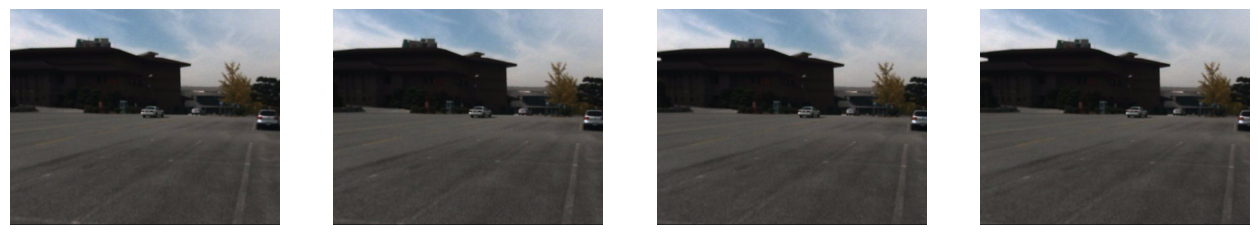

In [30]:
import matplotlib.pyplot as plt

#print("Data set image is ",dataset[:]['image'])
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[131:135]['image']):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [31]:
!pip install torchvision

In [32]:
from torchvision.transforms import functional as TF  # 변경된 부분
from PIL import ImageOps

def preprocess_image(image):
    # 원본 이미지 크기 가져오기
    w, h = image.size

    # 원하는 출력 크기
    target_w, target_h = config.image_size, config.image_size
    delta_w = target_w - w
    delta_h = target_h - h

    # 패딩 값 계산
    pad_left = delta_w // 2
    pad_right = delta_w - pad_left
    pad_top = delta_h // 2
    pad_bottom = delta_h - pad_top

    # 이미지에 패딩 추가 (PIL ImageOps 사용)
    padding = (pad_left, pad_top, pad_right, pad_bottom)  # 순서: (좌, 상, 우, 하)
    image = ImageOps.expand(image, border=padding, fill=0)

    # 텐서 변환 및 정규화
    image = TF.to_tensor(image)  # 변경된 부분
    image = TF.normalize(image, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 변경된 부분
    return image


In [33]:
def transform(examples):
    images = [preprocess_image(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

In [34]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [35]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [36]:
sample_image = dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)

print("Output shape:", model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


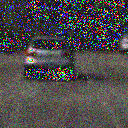

In [37]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [38]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [39]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [40]:
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device='cpu').manual_seed(config.seed), # Use a separate torch generator to avoid rewinding the random state of the main training loop
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [41]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

In [42]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

In [43]:
notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

events.out.tfevents.1732407593.e403d158e053.3671.0:   0%|          | 0.00/240k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

events.out.tfevents.1732407593.e403d158e053.3671.0:   0%|          | 0.00/400k [00:00<?, ?B/s]

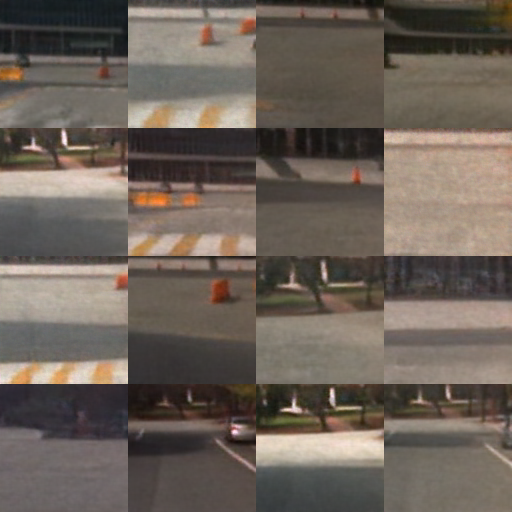

In [44]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))

Image.open(sample_images[-1])

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
from PIL import Image, ImageOps
from diffusers import UNet2DModel, DDPMScheduler
from huggingface_hub import login, HfApi, upload_folder
from glob import glob
import tqdm

login()

In [47]:
from dataclasses import dataclass

@dataclass
class Config:
    image_size: int = 128
    output_dir: str = "ddpm-kaist-128"  # local directory to save model and output
    model_dir: str = "koifisharriet/diffusion-pedestrian-detection-model"  # model directory in Hugging Face Hub
    dataset_dir: str = "/content/drive/MyDrive/CS7643_Deep_Learning/Pedestrian_Detection_Project/KAIST_Dataset/kaist_train"
    output_root: str = "ddpm-output"  # 결과물을 저장할 로컬 디렉토리
    repo_name: str = "koifisharriet/diffusion-pedestrian-detection-output"  # Hugging Face repo to upload model
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Config()

def get_image_paths(root_dir, mode='train_visible'):
    image_paths = []
    if mode == 'train_visible':
        for set_dir in sorted(glob(os.path.join(root_dir, 'set*'))):
            for v_dir in sorted(glob(os.path.join(set_dir, 'V*'))):
                img_dir = os.path.join(v_dir, 'visible')
                images = sorted(glob(os.path.join(img_dir, '*.jpg')))
                image_paths.extend(images)
    elif mode == 'train_lwir':
        for set_dir in sorted(glob(os.path.join(root_dir, 'set*'))):
            for v_dir in sorted(glob(os.path.join(set_dir, 'V*'))):
                img_dir = os.path.join(v_dir, 'lwir')
                images = sorted(glob(os.path.join(img_dir, '*.jpg')))
                image_paths.extend(images)
    else:
        raise ValueError("Invalid mode. Choose from 'train_visible' or 'train_lwir'")
    return image_paths

image_paths = get_image_paths(config.dataset_dir, mode='train_visible')



In [48]:

class KAISTDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path


transform = preprocess_image
dataset = KAISTDataset(image_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)



In [49]:
# save model
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)
pipeline.save_pretrained(config.output_dir)


In [50]:

from diffusers import UNet2DModel, DDPMPipeline

try:
    model = UNet2DModel.from_pretrained(config.model_dir)
    print("UNet2DModel loaded successfully.")
except OSError as e:
    print(f"model load failed: {e}")
    print("check 'config.json'과 'pytorch_model.bin' files exist in model directory")
    try:
        pipeline = DDPMPipeline.from_pretrained(config.model_dir)
        model = pipeline.unet
        model.eval()
        model.to(config.device)
        print("DDPMPipeline loaded UNet model.")
    except Exception as ex:
        print(f"DDPMPipeline load fail: {ex}")
        raise

model.eval()
model.to(config.device)


모델 로드 실패: koifisharriet/diffusion-pedestrian-detection-model does not appear to have a file named config.json.
모델 디렉토리에 'config.json'과 'pytorch_model.bin' 파일이 있는지 확인하세요.


model_index.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

unet/config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/497 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

DDPMPipeline에서 UNet 모델을 성공적으로 로드했습니다.


UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

In [51]:

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise_scheduler.set_timesteps(50)

In [ ]:

with torch.no_grad():
    for image, img_path in tqdm.tqdm(dataloader, desc="Processing images"):
        image = image.to(config.device)
        img_path = img_path[0]

        # random noise
        noise = torch.randn_like(image)
        noisy_image = noise

        # use model to generate images
        for t in noise_scheduler.timesteps:
            noise_pred = model(noisy_image, t).sample
            noisy_image = noise_scheduler.step(noise_pred, t, noisy_image).prev_sample

        generated_image = noisy_image.squeeze(0).cpu()
        generated_image = (generated_image * 0.5 + 0.5).clamp(0, 1)
        generated_image = TF.to_pil_image(generated_image)

        relative_path = os.path.relpath(img_path, config.dataset_dir)
        save_path = os.path.join(config.output_root, relative_path)
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        # save output
        generated_image.save(save_path)

In [ ]:

api = HfApi()

api.create_repo(repo_id=config.repo_name, repo_type="dataset", exist_ok=True)

upload_folder(
    repo_id=config.repo_name,
    folder_path=config.output_root,
    path_in_repo=".",
    repo_type="dataset",
    commit_message="Upload generated images",
)